In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [13]:
# Load the dataset
data_path = "C:\\Users\\nihar\\OneDrive\\Desktop\\Bootcamp\\SCMA 632\\DataSet\\NSSO68.csv"
try:
    data = pd.read_csv(data_path, low_memory=False)
    print("Data loaded successfully")
except FileNotFoundError:
    print(f"File not found at path: {data_path}")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Data loaded successfully


In [39]:
# Ensure the data is loaded
if 'data' in locals():
    # Create the Target variable
    data['non_veg'] = np.where(data[['eggsno_q', 'fishprawn_q', 'goatmeat_q', 'beef_q', 'pork_q', 'chicken_q', 'othrbirds_q']].sum(axis=1) > 0, 1, 0)


In [41]:
# Get the value counts of non_veg
non_veg_values = data['non_veg'].value_counts()
print(non_veg_values)

non_veg
1    68590
0    33072
Name: count, dtype: int64


In [43]:
# Ensure that the dataset contains both levels of the target variable
if data['non_veg'].nunique() < 2:
    raise ValueError("The dataset does not contain both levels of the target variable 'non_veg'.")


In [45]:
# Define the dependent variable (non_veg) and independent variables
y = data['non_veg']
X = data[['HH_type', 'Religion', 'Social_Group', 'Regular_salary_earner', 'Possess_ration_card', 'Sex', 'Age', 'Marital_Status', 'Education', 'Meals_At_Home', 'Region', 'hhdsz', 'NIC_2008', 'NCO_2004']]


In [47]:
# Convert relevant columns to categorical
X = pd.get_dummies(X, drop_first=True)

In [53]:
# Combine the dependent and independent variables into one dataframe
combined_data = pd.concat([y, X], axis=1)

In [55]:
# Inspect the combined data
print(combined_data.info())
print(combined_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101662 entries, 0 to 101661
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   non_veg                101662 non-null  int32  
 1   HH_type                101635 non-null  float64
 2   Religion               101659 non-null  float64
 3   Social_Group           101648 non-null  float64
 4   Regular_salary_earner  101650 non-null  float64
 5   Possess_ration_card    101649 non-null  float64
 6   Sex                    101662 non-null  int64  
 7   Age                    101662 non-null  int64  
 8   Marital_Status         101660 non-null  float64
 9   Education              101655 non-null  float64
 10  Meals_At_Home          100443 non-null  float64
 11  Region                 101662 non-null  int64  
 12  hhdsz                  101662 non-null  int64  
 13  NIC_2008               94151 non-null   float64
 14  NCO_2004               94175 non-nul

In [57]:
# Remove rows with missing values
combined_data = combined_data.dropna()

In [59]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state=123, stratify=combined_data['non_veg'])


In [61]:
# Fit the probit regression model on the training data
X_train = train_data.drop('non_veg', axis=1)
y_train = train_data['non_veg']
X_test = test_data.drop('non_veg', axis=1)
y_test = test_data['non_veg']

In [63]:
probit_model = sm.Probit(y_train, sm.add_constant(X_train)).fit()
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.589410
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                non_veg   No. Observations:                74476
Model:                         Probit   Df Residuals:                    74461
Method:                           MLE   Df Model:                           14
Date:                Mon, 01 Jul 2024   Pseudo R-squ.:                 0.05215
Time:                        22:45:32   Log-Likelihood:                -43897.
converged:                       True   LL-Null:                       -46312.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0086      0.062      0.139      0.890      -0.113       0.

In [65]:
# Predict probabilities on the test data
predicted_probs = probit_model.predict(sm.add_constant(X_test))

In [67]:
# Convert probabilities to binary predictions using a threshold of 0.5
predicted_classes = np.where(predicted_probs > 0.5, 1, 0)

In [69]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(conf_matrix)

[[  639  5198]
 [  417 12366]]


In [71]:
# Classification Report
class_report = classification_report(y_test, predicted_classes)
print(class_report)

              precision    recall  f1-score   support

           0       0.61      0.11      0.19      5837
           1       0.70      0.97      0.81     12783

    accuracy                           0.70     18620
   macro avg       0.65      0.54      0.50     18620
weighted avg       0.67      0.70      0.62     18620



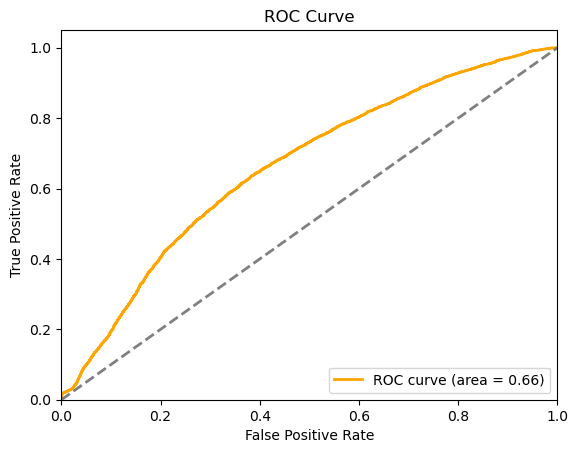

AUC: 0.6609746599619529


In [73]:
# ROC curve and AUC value
fpr, tpr, _ = roc_curve(y_test, predicted_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc}")

In [83]:
# Interpretation of metrics
accuracy = conf_matrix.diagonal().sum() / conf_matrix.sum()
precision = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.6984425349087003
Precision: 0.7040537462992484
Recall: 0.9673785496362356
F1 Score: 0.8149734734899661
